
 # 1) Chargement des données 

In [303]:
import pandas as pd
import re

def extract_data(input_path, pattern):
    with open(input_path, 'r') as file:
        content = file.read()
    matches = re.findall(pattern, content, re.MULTILINE)
    data = []
    for match in matches:
        numbers = match[1].replace('\n', ' ').split()
        numbers_float = [float(number) for number in numbers]
        data.append(numbers_float)
    return pd.DataFrame(data)

rocks_path = 'data/sonar.rocks'
mines_path = 'data/sonar.mines'


train_pattern = r'\*(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'
test_pattern = r'^(?!\*)(CR|CM)\d+:\n\{([\d\s\.\n]+)\}'


rocks_train_df = extract_data(rocks_path, train_pattern)
mines_train_df = extract_data(mines_path, train_pattern)
rocks_train_df['Label'] = 'R'  
mines_train_df['Label'] = 'M' 
train_df = pd.concat([rocks_train_df, mines_train_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

rocks_test_df = extract_data(rocks_path, test_pattern)
mines_test_df = extract_data(mines_path, test_pattern)
rocks_test_df['Label'] = 'R'  
mines_test_df['Label'] = 'M' 
test_df = pd.concat([rocks_test_df, mines_test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)


104
104


 # Partie 1

## 2) Apprentissage sur train

In [304]:
import numpy as np

def perceptron_batch(training_features, training_labels, epochs, learning_rate):

    
    weights = np.zeros(training_features.shape[1] + 1)
    
    
    for _ in range(epochs):
        
        update = np.zeros(training_features.shape[1] + 1)
        
        for inputs, label in zip(training_features, training_labels):
            
            activation = np.dot(inputs, weights[1:]) + weights[0]
            if activation >= 0:
                prediction = 1
            else:
                prediction = -1
            
            
            update[1:] += learning_rate * (label - prediction) * inputs
            update[0] += learning_rate * (label - prediction)
        
        
        weights += update
    
    return weights




train_df['Label'] = train_df['Label'].apply(lambda x: 1 if x == 'M' else -1)
test_df['Label'] = test_df['Label'].apply(lambda x: 1 if x == 'M' else -1)


train_features = train_df.iloc[:, :-1].values
train_labels = train_df.iloc[:, -1].values


weights = perceptron_batch(train_features, train_labels,22000,0.001)

### a) Calcul de Ea et de Eg

In [305]:
def predict_perceptron(inputs, weights):
    activation = np.dot(inputs, weights[1:]) + weights[0]
    return 1 if activation >= 0 else -1


def calculate_accuracy(features, labels, weights):
    predictions = [predict_perceptron(x, weights) for x in features]
    correct_predictions = sum(pred == label for pred, label in zip(predictions, labels))
    accuracy = correct_predictions / len(labels)
    return accuracy





test_features = test_df.iloc[:, :-1].values
test_labels = test_df.iloc[:, -1].values


training_accuracy = calculate_accuracy(train_features, train_labels, weights)
testing_accuracy = calculate_accuracy(test_features, test_labels, weights)


Ea = 1 - training_accuracy
Eg = 1 - testing_accuracy

print(f"Erreur d'apprentissage (Ea) : {Ea}")
print(f"Erreur de généralisation (Eg) : {Eg}")



Erreur d'apprentissage (Ea) : 0.0
Erreur de généralisation (Eg) : 0.1923076923076923


### b) Poids W

In [306]:
print("Les poids du perceptron",weights)

Les poids du perceptron [-0.98       0.842751   2.1072314  0.3838012  1.1038062  0.7259872
  1.4434456 -0.6594728 -1.5828186  0.0899288  1.0787674  0.38768
  0.1341432  0.0255996  0.042866   0.5863472 -1.958266  -0.5572258
  2.0306202 -0.378772  -0.0970566 -0.3937258  0.5972566 -0.440081
  1.078278  -0.1139262 -0.1252908  0.1074978 -0.2024282 -0.19539
  2.048143  -3.0649636  2.3248804 -1.6053052  0.743006  -0.4041242
 -0.2133034 -0.3860196 -0.2090698  1.7067118 -1.526431   0.636046
 -0.140197  -0.1147842 -0.6595438  1.1983514  1.035655  -1.0689164
  2.105948   2.8900536 -1.2872816  0.5331192  0.5126696  0.30002
  0.825407  -0.1197684 -0.2328594 -0.544665   0.3433368 -0.1490698
 -0.1637436]


### c) Fonction de stabilité

In [307]:
def calculate_stability(features, labels, weights):
    norm_w = np.linalg.norm(weights[1:])  
    stabilities = []
    for x, y in zip(features, labels):
        
        gamma = y * (np.dot(weights[1:], x) + weights[0]) / norm_w
        stabilities.append(gamma)
    return stabilities


test_stabilities = calculate_stability(test_features, test_labels, weights)


print(test_stabilities)

[0.028314955270346966, 0.030945614124018073, -0.023492685040119872, 0.00345330328702823, 0.05331840266117422, 0.021359085205937524, 0.024904576484386064, 0.058783706107623755, -0.10987461833133375, 0.12042269580187419, 0.1760521166831949, 0.09589829040586455, 0.06654454302777481, 0.13040261257309763, 0.11231781199792105, 0.1084141989543336, 0.06816456336079371, 0.06810040308189771, 0.04067017616194807, -0.0061959989213271754, 0.14910719515134188, 0.16423151163533803, 0.05971137071155062, 0.09047079036005659, 0.12787335649138598, 0.03950120294163979, 0.07983593435332437, -0.002168965686708738, -0.008394134711901508, 0.11095867882739069, 0.12096289657160741, 0.06127316022939052, -0.07474226052333291, 0.007769584353103857, -0.01257370954795979, -0.10534737547047462, 0.13282763219599567, 0.2026138800717195, 0.029767926209708567, -0.04335662826628602, 0.0734300360874828, -0.05038148598082326, 0.053710819471500144, 0.04688918152086441, 0.1461333010529333, 0.00040610387947636223, 0.0146261077

### d) Graph

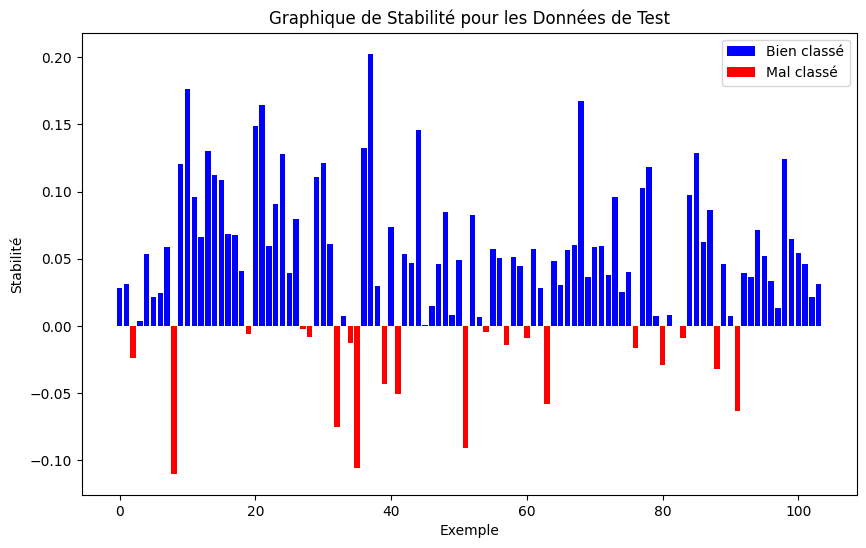

In [308]:
import matplotlib.pyplot as plt

def plot_stability(test_stabilities):
    
    labels = ['Bien classé' if val > 0 else 'Mal classé' for val in test_stabilities]

    
    plt.figure(figsize=(10, 6))

    
    plt.bar(range(len(test_stabilities)), [val if val > 0 else 0 for val in test_stabilities], 
            color='blue', label='Bien classé')

    
    plt.bar(range(len(test_stabilities)), [val if val < 0 else 0 for val in test_stabilities], 
            color='red', label='Mal classé')

    
    plt.legend()
    plt.xlabel('Exemple')
    plt.ylabel('Stabilité')
    plt.title('Graphique de Stabilité pour les Données de Test')

    
    plt.show()

plot_stability(test_stabilities)


## 3) Apprentissage sur "test"

Erreur d'apprentissage (Ea) : 0.0
Erreur de généralisation (Eg) : 0.24038461538461542
Les poids du perceptron [-0.328      0.0686126 -0.1159324 -0.077849   0.1135112  0.0488218
 -0.3204944 -0.5926774 -0.0325976  0.428619   0.1735732  0.6977114
  0.4804088  0.0313228 -0.120048  -0.3533744  0.1946254  0.0283746
 -0.1925738 -0.061936   0.101043   0.1632826  0.0522688  0.1890824
  0.1946074 -0.2644658 -0.2842268  0.029335   0.2229372  0.0131534
  0.0193636 -0.2111312  0.1043906 -0.0647168 -0.269177   0.1494514
 -0.1701704 -0.6112972 -0.066194   0.3420308 -0.2526802  0.122682
  0.146649   0.476997   0.623887   0.344156   0.043636   0.0806328
  0.2418556  0.0053686 -0.0403676  0.0975422  0.0670112  0.0267412
  0.016926   0.0034072  0.0148744  0.024501   0.0196874  0.0724016
  0.0097818]
Les valeurs de stabilité [-0.29891406466234527, 0.04116823979673454, -0.3107490558365038, -0.126448843322897, -0.023941075157824548, 0.19063133753394965, 0.016838594549710272, 0.24846904754396773, 0.061838776

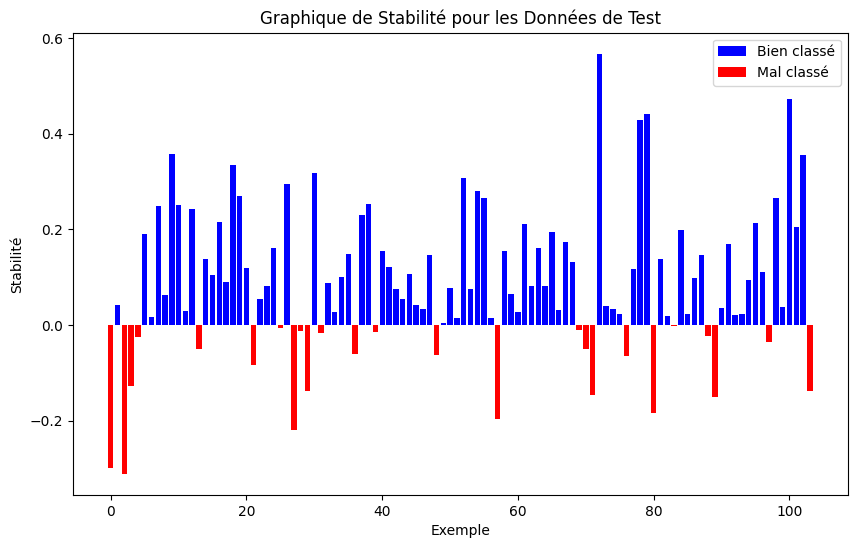

In [313]:

weights_T = perceptron_batch(test_features, test_labels,22000,0.001)

test_stabilities_T= calculate_stability(train_features, train_labels, weights_T)

training_accuracy_T = calculate_accuracy(test_features, test_labels, weights_T)
testing_accuracy_T = calculate_accuracy(train_features, train_labels, weights_T)


Ea = 1 - training_accuracy_T
Eg = 1 - testing_accuracy_T

print(f"Erreur d'apprentissage (Ea) : {Ea}")
print(f"Erreur de généralisation (Eg) : {Eg}")

print("Les poids du perceptron",weights_T)

print("Les valeurs de stabilité",test_stabilities_T)

plot_stability(test_stabilities_T)


# Partie 2

## 4) Algorithme Pocket

In [310]:
import time

def initialisation_de_hebb(training_features, training_labels):
    
    weights = np.zeros(training_features.shape[1] + 1)
    
    for inputs, label in zip(training_features, training_labels):
        weights[1:] += label * inputs
        weights[0] += label
    
    return weights

def pocket_algorithm(train_features, train_labels, test_features, test_labels,weights,max_iter=22000,max_err=0, learning_rate=0.1):
    
    best_weights = weights
    Nb_iterations = 0
    Ea=1
    
    while Nb_iterations < max_iter and Ea > max_err:
        
        update = np.zeros(train_features.shape[1] + 1)
        
        for inputs, label in zip(train_features, train_labels):
            
            activation = np.dot(inputs, weights[1:]) + weights[0]
            if activation >= 0:
                prediction = 1
            else:
                prediction = -1
            
            
            update[1:] += learning_rate * (label - prediction) * inputs
            update[0] += learning_rate * (label - prediction)
        
        
        weights += update
        
        
        Ea = 1 - calculate_accuracy(train_features, train_labels, weights)
        
        Eg = 1 - calculate_accuracy(test_features, test_labels, weights)
        
        if Eg < 1 - calculate_accuracy(test_features, test_labels, best_weights):
            best_weights = weights
        
        
        Nb_iterations += 1
    
    return best_weights,Nb_iterations

def compare_methods(training_features, training_labels, test_features, test_labels, learning_rate, max_iter, max_err):
    
    weights_random,Nb_iterations_random = pocket_algorithm(training_features, training_labels, test_features, test_labels, weights=np.random.rand(training_features.shape[1] + 1) * 2 - 1, max_iter=max_iter, max_err=max_err, learning_rate=learning_rate)
    
    
    weights_hebb, Nb_iterations_hebb = pocket_algorithm(training_features, training_labels, test_features, test_labels, weights=initialisation_de_hebb(training_features, training_labels), max_iter=max_iter, max_err=max_err, learning_rate=learning_rate)

    weights_exchange_random,Nb_iterations_exchange_random = pocket_algorithm(test_features, test_labels, training_features, training_labels,weights=np.random.rand(test_features.shape[1] + 1) * 2 - 1, max_iter=max_iter, max_err=max_err, learning_rate=learning_rate)
    
    weights_exchange_hebb,Nb_iterations_exchange_hebb = pocket_algorithm(test_features, test_labels, training_features, training_labels, weights=initialisation_de_hebb(test_features, test_labels), max_iter=max_iter, max_err=max_err, learning_rate=learning_rate)
    
    weights_pocket = [weights_random, weights_hebb, weights_exchange_random, weights_exchange_hebb]
    
    Nb_iterations_pocket = [Nb_iterations_random, Nb_iterations_hebb, Nb_iterations_exchange_random, Nb_iterations_exchange_hebb]

    
    Ea_pocket = [1-calculate_accuracy (training_features, training_labels, weights_random), 1-calculate_accuracy (training_features, training_labels, weights_hebb), 1-calculate_accuracy (test_features, test_labels, weights_exchange_random),1- calculate_accuracy (test_features, test_labels, weights_exchange_hebb)]
    Eg_pocket = [1- calculate_accuracy ( test_features, test_labels, weights_random),1- calculate_accuracy ( test_features, test_labels, weights_hebb),1- calculate_accuracy ( training_features, training_labels, weights_exchange_random),1- calculate_accuracy ( training_features, training_labels, weights_exchange_hebb)]
    
    print("Méthode\t\t\tEa\t\tEg\t\tNb_iterations")
    print("Random\t\t\t{:.4f}\t\t{:.4f}\t\t{}".format(Ea_pocket[0], Eg_pocket[0], Nb_iterations_pocket[0]))
    print("Hebb\t\t\t{:.4f}\t\t{:.4f}\t\t{}".format(Ea_pocket[1], Eg_pocket[1], Nb_iterations_pocket[1]))
    print("Echange Random\t\t{:.4f}\t\t{:.4f}\t\t{}".format(Ea_pocket[2], Eg_pocket[2], Nb_iterations_pocket[2]))
    print("Echange Hebb\t\t{:.4f}\t\t{:.4f}\t\t{}".format(Ea_pocket[3], Eg_pocket[3], Nb_iterations_pocket[3]))
    
    
    min_Eg = min(Eg_pocket)
    best_method = Eg_pocket.index(min_Eg)
    
    
    if best_method == 0:
        print("La meilleure méthode est Random")
    if best_method == 1:
        print("La meilleure méthode est Hebb")
    if best_method == 2:
        print("La meilleure méthode est Exchange Random")
    if best_method == 3:
        print("La meilleure méthode est Exchange Hebb")
    
    return weights_pocket
 

for learning_rate in [0.1, 0.01, 0.001]:
    start_time = time.time()
    weights_pocket = compare_methods(train_features, train_labels, test_features, test_labels, learning_rate=learning_rate, max_iter=22000, max_err=0.01)
    print(f"Temps d'exécution pour learning_rate={learning_rate} : ",{time.time() - start_time}, "secondes")
    print("\n")

Méthode			Ea		Eg		Nb_iterations
Random			0.0096		0.2019		14968
Hebb			0.0096		0.2019		14113
Exchange Random		0.0096		0.2308		1044
Exchange Hebb		0.0096		0.2404		993
La meilleure méthode est Random
Temps d'exécution pour learning_rate=0.1 :  {43.21446776390076} secondes


Méthode			Ea		Eg		Nb_iterations
Random			0.0096		0.2019		14114
Hebb			0.0096		0.2019		14368
Exchange Random		0.0096		0.2212		1018
Exchange Hebb		0.0096		0.2500		1073
La meilleure méthode est Random
Temps d'exécution pour learning_rate=0.01 :  {41.28294515609741} secondes


Méthode			Ea		Eg		Nb_iterations
Random			0.0096		0.2212		13330
Hebb			0.0096		0.2308		12718
Exchange Random		0.0096		0.2596		1888
Exchange Hebb		0.0096		0.2596		7489
La meilleure méthode est Random
Temps d'exécution pour learning_rate=0.001 :  {47.42716979980469} secondes




# Partie 3

## 5) Apprentissage sur "train et test"

Erreur d'apprentissage (Ea) : 0.09615384615384615
Erreur de généralisation (Eg) : 0.04807692307692313
Les poids du perceptron [-1.4060000e+00  2.7263776e+00  4.1823040e-01 -3.8693388e+00
  3.9574746e+00  3.3246620e-01  5.8838140e-01 -2.2077698e+00
 -1.5317032e+00  1.7412074e+00 -9.6917360e-01  2.3690888e+00
  5.8942460e-01 -4.5729000e-02 -3.4612540e-01  5.2547040e-01
 -5.0640340e-01 -1.2972996e+00  1.3238842e+00 -5.4880020e-01
  6.9305680e-01 -8.4891400e-01  1.2442930e+00 -9.2581080e-01
  1.9959568e+00 -8.2241560e-01 -3.5189720e-01  4.6993780e-01
 -3.1498480e-01 -1.6604240e-01  1.8712528e+00 -3.0814922e+00
  1.5055166e+00  2.3477480e-01 -9.9478860e-01  1.5755438e+00
 -1.7375118e+00 -3.5191160e-01  1.4334580e-01  1.3185718e+00
 -2.0211816e+00  5.7359440e-01  8.4407000e-02  5.5505540e-01
  5.0507020e-01  8.4901400e-01  9.5330800e-02  2.6794000e-03
  3.2833850e+00  3.7186640e+00 -2.8747132e+00  2.5147360e+00
  2.1065308e+00  1.4150502e+00  1.2052510e+00 -1.9851300e-01
 -3.7440880e-01 -9.0

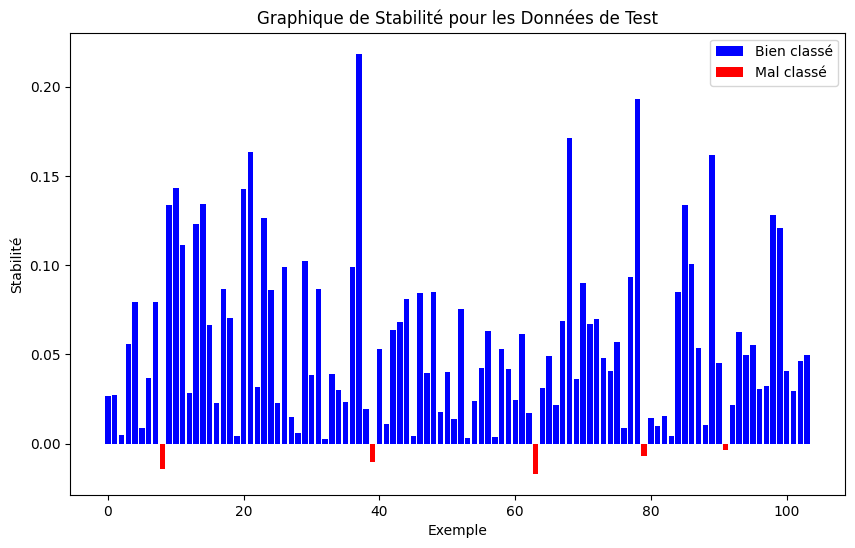

In [321]:
train_test_df = pd.concat([train_df, test_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

train_test_features = train_test_df.iloc[:, :-1].values
train_test_labels = train_test_df.iloc[:, -1].values

train_test_weights = perceptron_batch(train_test_features, train_test_labels,22000,0.001)

train_accuracy = calculate_accuracy(train_test_features, train_test_labels, train_test_weights)
test_accuracy = calculate_accuracy(test_features, test_labels, train_test_weights)

Ea = 1 - train_accuracy
Eg = 1 - test_accuracy

print(f"Erreur d'apprentissage (Ea) : {Ea}")
print(f"Erreur de généralisation (Eg) : {Eg}")
print("Les poids du perceptron",train_test_weights)

test_stabilities_L = calculate_stability(test_features, test_labels, train_test_weights)

print("Les valeurs de stabilité",test_stabilities_L)

plot_stability(test_stabilities_L)

# Partie 4

## 6) Early Stopping

In [312]:
import numpy as np
import pandas as pd

train_test_df = train_test_df.sample(frac=1, random_state=1).reset_index(drop=True)

def perceptron_batch_avec_ES(features, labels, validation_features, validation_labels, epochs, learning_rate, patience):
    weights = np.zeros(features.shape[1] + 1)
    best_weights = None
    meilleur_validation_accuracy = 0
    patience_counter = 0
    early_stop_epoch = 0  

    for epoch in range(epochs):
        update = np.zeros(features.shape[1] + 1)
        for inputs, label in zip(features, labels):
            activation = np.dot(inputs, weights[1:]) + weights[0]
            prediction = 1 if activation >= 0 else -1
            update[1:] += learning_rate * (label - prediction) * inputs
            update[0] += learning_rate * (label - prediction)
        weights += update

        validation_accuracy = calculate_accuracy(validation_features, validation_labels, weights)

        if validation_accuracy > meilleur_validation_accuracy:
            meilleur_validation_accuracy = validation_accuracy
            meilleur_weights = weights.copy()
            patience_counter = 0
            early_stop_epoch = epoch
        else:
            patience_counter += 1

        
        if patience_counter >= patience:
            break

    return meilleur_weights if meilleur_weights is not None else weights, early_stop_epoch


num_experiments = 5
errors_train = []
errors_validation = []
errors_test = []
early_stop_epochs = []

for _ in range(num_experiments):
    train_test_df = train_test_df.sample(frac=1, random_state=1).reset_index(drop=True)
    
    LA_df, remaining_df = np.split(train_test_df, [int(.5*len(train_test_df))])
    LV_df, LT_df = np.split(remaining_df, [int(.5*len(remaining_df))])

    LA_features, LA_labels = LA_df.iloc[:, :-1].values, LA_df.iloc[:, -1].values
    LV_features, LV_labels = LV_df.iloc[:, :-1].values, LV_df.iloc[:, -1].values
    LT_features, LT_labels = LT_df.iloc[:, :-1].values, LT_df.iloc[:, -1].values

    
    best_weights, stop_epoch = perceptron_batch_avec_ES(LA_features, LA_labels, LV_features, LV_labels,
                                                        epochs=22000, learning_rate=0.001, patience=2000)
    early_stop_epochs.append(stop_epoch)

    
    errors_train.append(1 - calculate_accuracy(LA_features, LA_labels, best_weights))
    errors_validation.append(1 - calculate_accuracy(LV_features, LV_labels, best_weights))
    errors_test.append(1 - calculate_accuracy(LT_features, LT_labels, best_weights))

mean_error_train = np.mean(errors_train)
mean_error_validation = np.mean(errors_validation)
mean_error_test = np.mean(errors_test)

print(f"Erreur moyenne d'apprentissage (Ea): {mean_error_train}")
print(f"Erreur moyenne de validation (Ev): {mean_error_validation}")
print(f"Erreur moyenne de test (Et): {mean_error_test}")

mean_early_stop_epoch = np.mean(early_stop_epochs)
print(f"Epoch moyenne d'arrêt prématuré : {mean_early_stop_epoch}")


Erreur moyenne d'apprentissage (Ea): 0.1519230769230769
Erreur moyenne de validation (Ev): 0.15384615384615383
Erreur moyenne de test (Et): 0.23076923076923075
Epoch moyenne d'arrêt prématuré : 694.6
